In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
# Load original data
data_23 = pd.read_csv("data/0901_Tek023.csv")
print("Original data shape:", data_23.shape)
data_23.head()

Original data shape: (39, 3)


,n,vth_average,t
0,0,0.914897,0.00000
1,1,1.012521,0.00001
2,2,1.030124,0.00002
3,4,1.053786,0.00004
4,8,1.073705,0.00008


In [3]:
# Extract time and vth_average
t_original = data_23["t"].values
vth_original = data_23["vth_average"].values

print("Time range:", t_original.min(), "to", t_original.max())
print("Number of original points:", len(t_original))

Time range: 0.0 to 10000.0
Number of original points: 39


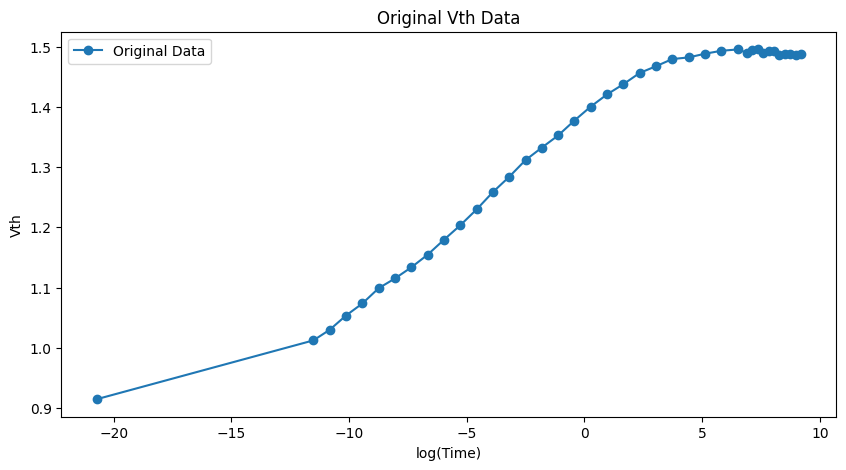

In [4]:
# Plot original data
plt.figure(figsize=(10, 5))
plt.plot(np.log(t_original + 1e-9), vth_original, 'o-', label="Original Data")
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Original Vth Data")
plt.legend()
plt.show()

## Interpolation Methods
We'll try several interpolation methods:
1. Linear interpolation
2. Cubic spline interpolation
3. PCHIP (Piecewise Cubic Hermite Interpolating Polynomial) - preserves monotonicity

In [5]:
# Use log(time) for interpolation since data is logarithmic
epsilon = 1e-9
log_t_original = np.log(t_original + epsilon)

# Create interpolation functions
f_linear = interpolate.interp1d(log_t_original, vth_original, kind='linear', fill_value='extrapolate')
f_cubic = interpolate.interp1d(log_t_original, vth_original, kind='cubic', fill_value='extrapolate')
f_pchip = interpolate.PchipInterpolator(log_t_original, vth_original, extrapolate=True)

In [6]:
# Generate new time points (more dense)
# Create 500 points evenly spaced in log(time)
log_t_new = np.linspace(log_t_original.min(), log_t_original.max(), 500)
t_new = np.exp(log_t_new) - epsilon

print("Number of interpolated points:", len(t_new))

Number of interpolated points: 500


In [7]:
# Interpolate vth values
vth_linear = f_linear(log_t_new)
vth_cubic = f_cubic(log_t_new)
vth_pchip = f_pchip(log_t_new)

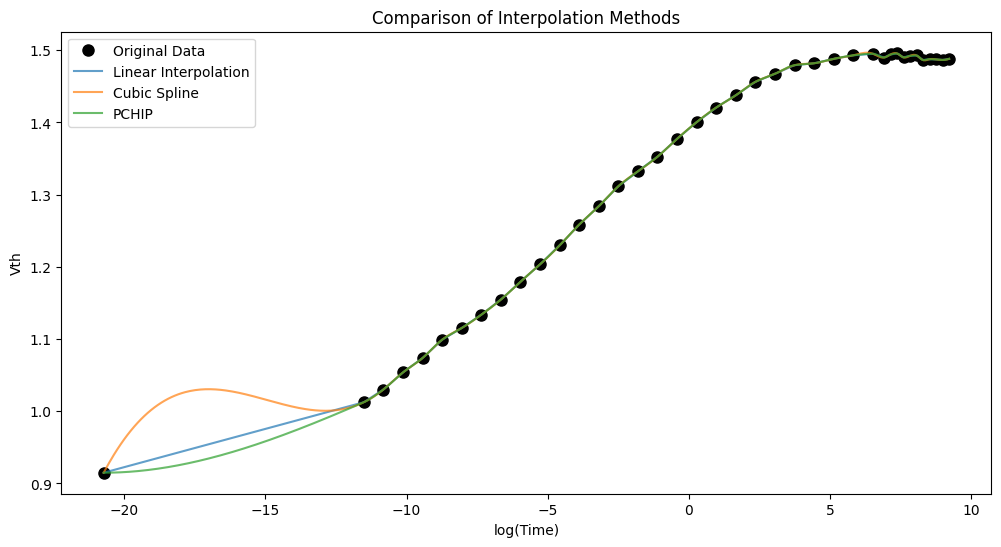

In [8]:
# Plot all interpolation methods
plt.figure(figsize=(12, 6))
plt.plot(log_t_original, vth_original, 'ko', markersize=8, label="Original Data")
plt.plot(log_t_new, vth_linear, '-', alpha=0.7, label="Linear Interpolation")
plt.plot(log_t_new, vth_cubic, '-', alpha=0.7, label="Cubic Spline")
plt.plot(log_t_new, vth_pchip, '-', alpha=0.7, label="PCHIP")
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Comparison of Interpolation Methods")
plt.legend()
plt.show()

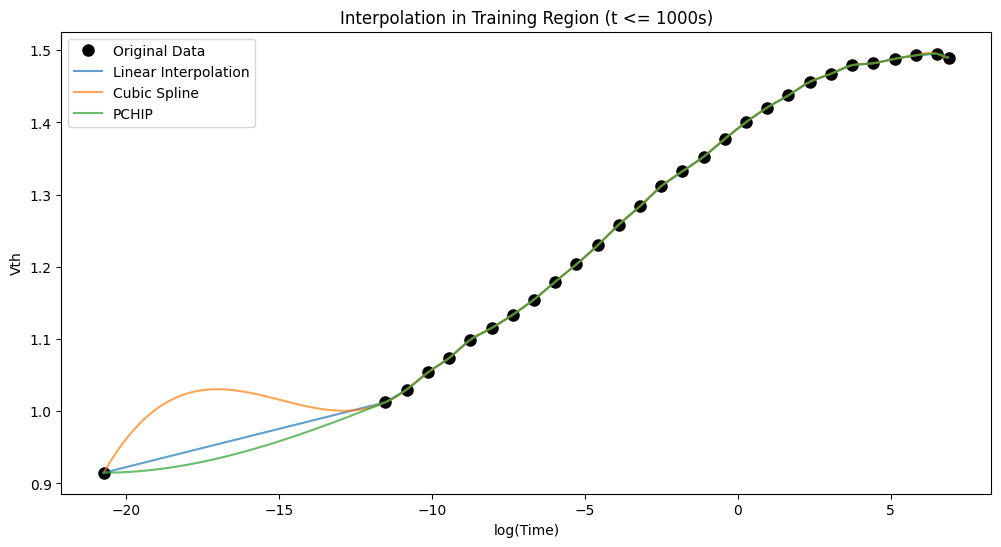

In [9]:
# Zoom into the training region (first 1000s, approximately first 29 points)
train_mask_original = t_original <= 1000
train_mask_new = t_new <= 1000

plt.figure(figsize=(12, 6))
plt.plot(log_t_original[train_mask_original], vth_original[train_mask_original], 'ko', markersize=8, label="Original Data")
plt.plot(log_t_new[train_mask_new], vth_linear[train_mask_new], '-', alpha=0.7, label="Linear Interpolation")
plt.plot(log_t_new[train_mask_new], vth_cubic[train_mask_new], '-', alpha=0.7, label="Cubic Spline")
plt.plot(log_t_new[train_mask_new], vth_pchip[train_mask_new], '-', alpha=0.7, label="PCHIP")
plt.xlabel("log(Time)")
plt.ylabel("Vth")
plt.title("Interpolation in Training Region (t <= 1000s)")
plt.legend()
plt.show()

## Save Interpolated Data
We'll use PCHIP interpolation as it preserves the shape of the data well without oscillations.

In [10]:
# Create interpolated dataframe using PCHIP
data_23_interpolated = pd.DataFrame({
    't': t_new,
    'log_t': log_t_new,
    'vth_average': vth_pchip
})

print("Interpolated data shape:", data_23_interpolated.shape)
data_23_interpolated.head()

Interpolated data shape: (500, 3)


,t,log_t,vth_average
0,6.203855e-25,-20.723266,0.914897
1,6.182294e-11,-20.663279,0.914903
2,1.274680e-10,-20.603291,0.914920
3,1.971713e-10,-20.543304,0.914949
4,2.711840e-10,-20.483317,0.914989


In [11]:
# Save to CSV
data_23_interpolated.to_csv("data/0901_Tek023_interpolated.csv", index=False)
print("Interpolated data saved to data/0901_Tek023_interpolated.csv")

Interpolated data saved to data/0901_Tek023_interpolated.csv


In [12]:
# Also create interpolated versions for other datasets
def interpolate_dataset(filepath, num_points=500):
    data = pd.read_csv(filepath)
    t_orig = data["t"].values
    vth_orig = data["vth_average"].values
    
    log_t_orig = np.log(t_orig + epsilon)
    f_pchip = interpolate.PchipInterpolator(log_t_orig, vth_orig, extrapolate=True)
    
    log_t_new = np.linspace(log_t_orig.min(), log_t_orig.max(), num_points)
    t_new = np.exp(log_t_new) - epsilon
    vth_new = f_pchip(log_t_new)
    
    return pd.DataFrame({
        't': t_new,
        'log_t': log_t_new,
        'vth_average': vth_new
    })

# Interpolate all datasets
data_24_interpolated = interpolate_dataset("data/0901_Tek024.csv")
data_25_interpolated = interpolate_dataset("data/0901_Tek025.csv")
data_31_interpolated = interpolate_dataset("data/0901_Tek031.csv")

# Save all
data_24_interpolated.to_csv("data/0901_Tek024_interpolated.csv", index=False)
data_25_interpolated.to_csv("data/0901_Tek025_interpolated.csv", index=False)
data_31_interpolated.to_csv("data/0901_Tek031_interpolated.csv", index=False)

print("All interpolated datasets saved!")

All interpolated datasets saved!


In [13]:
# Summary statistics
print("\n=== Summary ===")
print(f"Original data points: {len(t_original)}")
print(f"Interpolated data points: {len(t_new)}")
print(f"\nOriginal training points (t <= 1000s): {sum(train_mask_original)}")
print(f"Interpolated training points (t <= 1000s): {sum(train_mask_new)}")


=== Summary ===
Original data points: 39
Interpolated data points: 500

Original training points (t <= 1000s): 29
Interpolated training points (t <= 1000s): 461
